In [75]:
import random
import redis

In [76]:
random.seed(444)

In [77]:
hats = {f"hat:{random.getrandbits(32)}": i for i in (
    {
        "color": "black",
        "price": 49.99,
        "style": "fitted",
        "quantity": 1000,
        "npurchased": 0,
    },
    {
        "color": "maroon",
        "price": 59.99,
        "style": "hipster",
        "quantity": 500,
        "npurchased": 0,
    },
    {
        "color": "green",
        "price": 99.99,
        "style": "baseball",
        "quantity": 200,
        "npurchased": 0,
    })
          }

In [78]:
tshirts = {f"t-shirt:{random.getrandbits(32)}": i for i in (
    {
        "color": "black",
        "price": 19.99,
        "style": "fitted",
        "quantity": 2000,
        "npurchased": 0,
    },
    {
        "color": "yellow",
        "price": 29.99,
        "style": "hipster",
        "quantity": 450,
        "npurchased": 0,
    },
    {
        "color": "green",
        "price": 39.99,
        "style": "large",
        "quantity": 400,
        "npurchased": 0,
    })}

In [79]:
jeans = {f"jeans:{random.getrandbits(32)}": i for i in (
    {
        "color": "black",
        "price": 59.99,
        "style": "fitted",
        "quantity": 3000,
        "npurchased": 0,
    },
    {
        "color": "bleu",
        "price": 69.99,
        "style": "slim",
        "quantity": 400,
        "npurchased": 0,
    },
    {
        "color": "dark blue",
        "price": 89.99,
        "style": "straight",
        "quantity": 600,
        "npurchased": 0,
    })}

In [80]:
catalog = {}
for i in [hats, tshirts, jeans]:
    for j in i.items():
        catalog[j[0]] = j[1]

In [81]:
#r = redis.Redis(host='localhost', port=8888, db=1)
r = redis.Redis(db=1)

In [82]:
r.flushdb()

True

In [83]:
with r.pipeline() as pipe:
    for _id, i in catalog.items():
        pipe.hmset(_id, i)
    pipe.execute()

In [84]:
#r.bgsave()

In [85]:
def get_updated_catalog():
    catalog = {}
    for key in r.keys():
        catalog[key] = get_item_info(key)
    return catalog

In [86]:
import re

def clean(el):
    el_clean = re.findall("'.*'", el)
    el_clean = re.sub("'", '', el_clean[0])
    return el_clean

def clean_results(res):
    new_res = {}
    for i in res.items():
        field = str(i[0])
        value = str(i[1])
        field_clean = clean(field)
        value_clean = clean(value)
        new_res[field_clean] = value_clean
    return new_res

In [87]:
def get_item_info(item, fields = 'All'):
    if fields == 'All':
        result = r.hgetall(item)
    #else:
    return clean_results(result)

In [88]:
def update_item_info(item, field, new_value=None, func = 'add'):
    if func == 'add':
        r.hset(item, field, new_value)
    else:
        r.hdel(item, field)

In [89]:
example = r.keys()[0] 
example

b'jeans:1296359138'

In [90]:
update_item_info(example, 'color', 'purple')

In [91]:
print(r.hgetall(example))

{b'color': b'purple', b'price': b'69.99', b'style': b'slim', b'quantity': b'400', b'npurchased': b'0'}


In [92]:
update_item_info(example, 'size', 'oversize')

In [93]:
print(r.hgetall(example))

{b'color': b'purple', b'price': b'69.99', b'style': b'slim', b'quantity': b'400', b'npurchased': b'0', b'size': b'oversize'}


In [94]:
update_item_info(example, 'size', func = 'del')

In [95]:
print(r.hgetall(example))

{b'color': b'purple', b'price': b'69.99', b'style': b'slim', b'quantity': b'400', b'npurchased': b'0'}


In [96]:
def add_item(d):
    with r.pipeline() as pipe:
        for _id, i in d.items():
            pipe.hmset(_id, i)
        pipe.execute()

In [97]:
new_item = {'hat:1326692455': {'color': 'green',
  'price': 50.99,
  'style': 'onesize',
  'quantity': 10,
  'npurchased': 2}}

In [98]:
len(r.keys())

9

In [99]:
add_item(new_item)

In [100]:
len(r.keys())

10

In [101]:
def get_keys(item_type):
    di = {}
    di[item_type] = random.getrandbits(32)
    for k,v in di.items():
        key_val_pair = str(k)+":"+str(v)
    return key_val_pair

In [102]:
get_keys('jeans')

'jeans:2207557033'

Функция ниже уменьшает количество товара и увеличивает число преобретений

In [103]:
import logging

logging.basicConfig()
class OutOfStockError(Exception):
    """Используется, когда на PyHats заканчивается самый популярный товар"""
    
def buyitem(r: redis.Redis, itemid: int) -> None:
    with r.pipeline() as pipe:
        error_count = 0
        while True:
            try:
                # Получение доступного инвентаря, поиск изменений
                # связанных с ID объекта перед транзакцией
                pipe.watch(itemid)
                nleft: bytes = r.hget(itemid, "quantity")
                if nleft > b"0": #проверяет, не пустой ли
                    pipe.multi()
                    pipe.hincrby(itemid, "quantity", -1)
                    pipe.hincrby(itemid, "npurchased", 1)
                    pipe.execute()
                    break
                else:
                    # Остановка поиска ID объекта
                    pipe.unwatch()
                    raise OutOfStockError(
                        f"Sorry, {itemid} is out of stock!"
                    )
            except redis.WatchError:
                # Регистрация общего количества ошибок данного пользователя,
                # с последующей попыткой повторения процесса WATCH/HGET/MULTI/EXEC
                error_count += 1
                logging.warning(
                    "WatchError #%d: %s; retrying",
                    error_count, itemid
                )
    return None

In [104]:
r.hmget(example, "quantity", "npurchased")

[b'400', b'0']

In [105]:
def buy_stuff(example, num):
    max_num = int(r.hmget(example, "quantity")[0])
    if num < max_num:
        for i in range(num):
            buyitem(r, example)
        return 'Thanks for purchasing!'
    else:
        return f'Sorry, there is only {max_num} of this item left'

In [124]:
buy_stuff(example, 10)

'Thanks for purchasing!'

In [107]:
r.hmget(example, "quantity", "npurchased")

[b'390', b'10']

In [108]:
buy_stuff(example, 400)

'Sorry, there is only 390 of this item left'

In [109]:
def delete_item(item):
    r.delete(item)

In [110]:
import random

nouns = ['Feeling', 'Heat', 'Light', 'Move', 'Summer', 'Touch', 'Love', 'Spring', 'Winter', 'Sun', 'Smile', 'Time', 'Sound On', 'Be Unique', 'Work Hard', 'Holiday', 'School Day', 'Strange Bird']

In [111]:
def get_name(key, custom_name = None):
    if custom_name == None:
        s = str(key).split(':')[0].title() +" "+ "«" + random.choice(nouns) + "»"
        s = s[2:]
    else:
        s = str(key)[2:].split(':')[0].title() +" "+ "«" + str(custom_name) + "»"
    return s

In [112]:
def give_me_name(d, key, custom_name = None):
    param = 0
    while param == 0:
        if custom_name == None:
            name = get_name(key)
        else:
            name = get_name(key, custom_name)
        threshold = 0
        for k, value in d.items():
            if value != name:
                threshold += 1
        if threshold == len(d.keys()):
            param = 1
    return name        

In [113]:
d = {}
for key in r.keys():
    d[key] = give_me_name(d, key)

In [114]:
d

{b'jeans:1296359138': 'Jeans «Work Hard»',
 b't-shirt:1327727452': 'T-Shirt «Strange Bird»',
 b'hat:56854717': 'Hat «Sun»',
 b'hat:1236154736': 'Hat «Holiday»',
 b'jeans:3700028109': 'Jeans «Light»',
 b'hat:1326692455': 'Hat «Be Unique»',
 b't-shirt:2080643381': 'T-Shirt «Love»',
 b'hat:1326692461': 'Hat «Feeling»',
 b't-shirt:1186298464': 'T-Shirt «Move»',
 b'jeans:3189613171': 'Jeans «Feeling»'}

In [115]:
def update_d(custom_name = None):
    if custom_name == None:
        for key in r.keys():
            if key not in d.keys():
                d[key] = give_me_name(d, key) #add new keys
    else:
        for key in r.keys():
            if key not in d.keys():
                d[key] = give_me_name(d, key, custom_name) #add new keys with cn
            
    for key in list(d.keys()):
        if key not in r.keys():
            del d[key] #delete keys of deleted items

In [116]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [117]:
def get_types():
    types = []
    for key in r.keys():
        s = str(key).split(':')[0].title()
        types.append(s[2:])
    return set(types)

In [118]:
get_types()

{'Hat', 'Jeans', 'T-Shirt'}

In [119]:
def clean_mas(mas):
    mas = str(mas)
    str_len = len(mas)
    mas = mas[1:str_len-1]
    return mas.replace("'", "")

In [120]:
clean_mas(get_types())

'T-Shirt, Jeans, Hat'

In [121]:
import re
import matplotlib.pyplot as plt
import numpy as np

In [122]:
def get_plot():
    npurchased = {}
    for i in r.keys():
        reg = re.search(r'b\'(.*?):', str(i))
        reg1 = re.search(r'\d', str(r.hmget(i, "npurchased")))
        if reg1 is not None:
            if reg.group(1) not in npurchased.keys():
                npurchased[reg.group(1)] = [reg1.group()]
            else:
                npurchased[reg.group(1)].extend(reg1.group())

    for keys in npurchased:
        summ = 0
        for i in npurchased[keys]:
            num = int(i)
            summ += num
            npurchased[keys] = summ

    lists = sorted(npurchased.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples

    plt.plot(x, y, linewidth=5)
    plt.ylim(0)
    #plt.yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.title('The purchase graph')

    plt.savefig('static/plot.png')

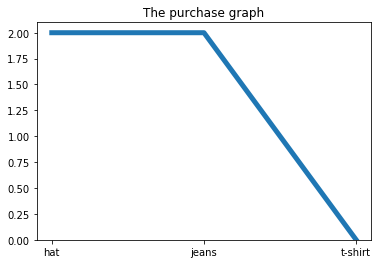

In [125]:
get_plot()

FLASK

In [126]:
from flask import Flask
from flask import render_template, request
import json
import random

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:43] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:43] "GET /main.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:45] "GET /buy_page HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:45] "GET /main.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:52] "GET /results?chose=T-Shirt+«Move»&quantity=10 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:52] "GET /main.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:54] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:54] "GET /main.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:55] "GET /buy_page HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:15:55] "GET /main.css HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [05/Apr/2020 14:16:06] "GET /results?chose=Jeans+«Feeling»&qua

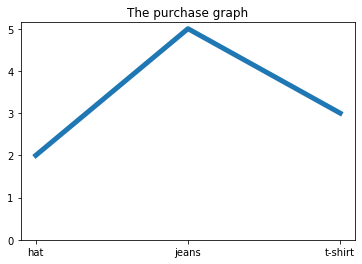

In [129]:
app = Flask(__name__)

@app.route('/')
def search():
    updated_catalog = get_updated_catalog()
    update_d()
    return render_template('main_2.html', catalog = updated_catalog, di = d)

@app.route('/buy_page')
def buy():    
    update_d()
    items = [d[key] for key in d.keys()]
    return render_template('buy_page.html', items = items)

@app.route('/results')
def results():
    update_d()
    quantity = request.args['quantity']
    item = request.args['chose']
    key = get_key(d, item)
    results = buy_stuff(key, int(quantity))
    return render_template('merci.html', result = results) 

@app.route('/update_page_0')
def update():
    update_d()
    items = [d[key] for key in d.keys()]
    return render_template('update_page_0.html', items = items)

@app.route('/update_page')
def update_results():
    update_d()
    update_func = request.args['update_func']
    update_item = request.args['update_chose']
    add_num = request.args['add_num']
    
    if update_item != 'NEW_ITEM':
        item = get_key(d, update_item)
        item_values = get_item_info(item).keys()
    
    updated_catalog = get_updated_catalog()
    item_types = clean_mas(get_types())
   
    if update_func == 'delete':
        return render_template('update_del.html', update_item = update_item, item_values = item_values)
    
    if update_func == 'update':
        return render_template('update_update.html', update_item = update_item, item_values = item_values)
    
    if update_func == 'add' and update_item == 'NEW_ITEM':
        return render_template('update_add_new.html', item_types = item_types, add_num = int(add_num))
    else:
        return render_template('update_add.html', item_name = update_item, item_info = updated_catalog[item], add_num = int(add_num))
        

@app.route('/del_results')
def del_results():
    update_d()
    item_name = request.args['item_name']
    #del_results = request.args['select_res']
    
    item = get_key(d, item_name)
    item_values = get_item_info(item).keys()
    del_results = []
    for i in item_values:
        try:
            del_value = request.args[i]
            del_results.append(del_value)
        except:
            continue
            
    item_value = None
    try:
        item_value = request.args['item']
    except:
        pass
        
    if item_value == "item":
        delete_item(item)
        del_results = 'all fields'
    else:
        for field in del_results:
            update_item_info(item, field, func = 'del')
        del_results = clean_mas(del_results)
        
    return render_template('del_result.html', item_name = item_name, del_results = del_results)

@app.route('/update_results')
def update_result():
    update_d()
    item_name = request.args['item_name']
    
    item = get_key(d, item_name)
    item_values = get_item_info(item).keys()
    
    #update_results = []
    for i in item_values:
        try:
            update_value = request.args[i]
            #update_results.append(update_value)
            update_item_info(item, i, update_value)
        except:
            continue
        
    return render_template('update_result.html', item_name = item_name)

@app.route('/add_results')
def add_result():    
    update_d()
    item_name = request.args['item_name']
    add_num = request.args['add_num']
    item = get_key(d, item_name)
    
    new_data = []
    for i in range(int(add_num)):
        try:
            new_field = request.args[str(i+10)]
            new_value = request.args[str(i)]
            update_item_info(item, new_field, new_value)
            new_data.append(new_field)
        except:
            continue
            
    new_data = clean_mas(new_data)
    
    return render_template('add_result.html', item_name = item_name, new_fields = new_data)

@app.route('/add_results_new')
def add_result_new():    
    update_d()
    new_item_name = request.args['item_name']
    new_type = request.args['new_type']
    add_num = request.args['add_num']
    
    new_key = get_keys(new_type)
    
    new_data = {}
    for i in range(int(add_num)):
        try:
            new_field = request.args[str(i+10)]
            new_value = request.args[str(i)]
            new_data[new_field] = new_value
        except:
            continue
            
    if 'quantity' not in new_data.keys():
        new_data['quantity'] = 0
    if 'npurchased' not in new_data.keys():
        new_data['npurchased'] = 0
        
    new_item = {new_key: new_data}
    add_item(new_item)
    update_d(custom_name = new_item_name)
    
    return render_template('add_result_new.html', item_name = new_item_name, type_name = new_type, new_fields = new_data)


@app.route('/stats')
def stats():    
    get_plot()
    return render_template('stats.html')

if __name__ == '__main__':
    app.run()

Сортировка + группировка

In [52]:
r2 = redis.Redis(db=2)
r2.flushdb()

True

In [53]:
with r2.pipeline() as pipe:
    for _id, i in catalog.items():
        pipe.hmset(_id, i)
    pipe.execute()

In [54]:
def get_clean_id(key):
    res = str(key).split(':')[1]
    return res[:-1]

In [55]:
ids = []
for i in r2.keys():
    ids.append(int(get_clean_id(i)))

In [56]:
ids

[1296359138,
 1327727452,
 56854717,
 1236154736,
 3700028109,
 2080643381,
 1326692461,
 1186298464,
 3189613171]

In [57]:
for i in ids:
    r2.sadd("item_ids", i)

In [58]:
item_types = clean_mas(get_types()).lower()
item_types

't-shirt, jeans, hat, "item_ids"'

In [59]:
item_types = item_types.split(', ')

In [60]:
def sort_group(item_type, field):
    type_sorted = []
    sort1 = r2.sort("item_ids", by=f"{item_type}:*->{field}")
    sort2 = r2.sort("item_ids", by=f"{item_type}:*->{field}", get = f"{item_type}:*->{field}")
    return sort1, sort2

In [61]:
res1, res2 = sort_group('t-shirt', 'price')

In [62]:
res1

[b'1236154736',
 b'1296359138',
 b'1326692461',
 b'3189613171',
 b'3700028109',
 b'56854717',
 b'1327727452',
 b'2080643381',
 b'1186298464']

In [63]:
res2

[None, None, None, None, None, None, b'19.99', b'29.99', b'39.99']

In [64]:
def get_clean_id_2(key):
    if key != b'item_ids':
        res = str(key).split(':')[0][:2] + str(key).split(':')[1]
        return res

In [65]:
def get_gp_sr(res1, res2):
    mas_dop = []
    for k in range(len(res1)):
        if res2[k] != None:
            for key in r2.keys():
                if res1[k] != b'item_ids':
                    if get_clean_id_2(key) == str(res1[k]):
                        dop = {key: r2.hgetall(key)}
                        mas_dop.append(dop)
    return mas_dop

In [66]:
def get_all_gp_sr(item_type, field):
    res1, res2 = sort_group(item_type, field)
    results = get_gp_sr(res1, res2)
    return results

In [67]:
get_all_gp_sr('t-shirt', 'price')

[{b't-shirt:1327727452': {b'color': b'black',
   b'price': b'19.99',
   b'style': b'fitted',
   b'quantity': b'2000',
   b'npurchased': b'0'}},
 {b't-shirt:2080643381': {b'color': b'yellow',
   b'price': b'29.99',
   b'style': b'hipster',
   b'quantity': b'450',
   b'npurchased': b'0'}},
 {b't-shirt:1186298464': {b'color': b'green',
   b'price': b'39.99',
   b'style': b'large',
   b'quantity': b'400',
   b'npurchased': b'0'}}]

In [68]:
def all_types_gp_sr(types, field):
    all_results = []
    for i in types:
        if i != b'item_ids':
            type_res = get_all_gp_sr(i, field)
        for j in type_res:
            all_results.append(j)
    return all_results        

In [69]:
def nice_output(mas, field):
    for i in mas:
        for key in i.keys():
            for s_key in i[key].keys():
                if s_key == field:
                    print(key, i[key][s_key])

In [70]:
nice_output(all_types_gp_sr(item_types, 'price'), b'price')

b't-shirt:1327727452' b'19.99'
b't-shirt:2080643381' b'29.99'
b't-shirt:1186298464' b'39.99'
b'jeans:3700028109' b'59.99'
b'jeans:1296359138' b'69.99'
b'jeans:3189613171' b'89.99'
b'hat:1326692461' b'49.99'
b'hat:1236154736' b'59.99'
b'hat:56854717' b'99.99'


In [72]:
nice_output(all_types_gp_sr(item_types, 'quantity'), b'quantity')

b't-shirt:1186298464' b'400'
b't-shirt:2080643381' b'450'
b't-shirt:1327727452' b'2000'
b'jeans:1296359138' b'400'
b'jeans:3189613171' b'600'
b'jeans:3700028109' b'3000'
b'hat:56854717' b'200'
b'hat:1236154736' b'500'
b'hat:1326692461' b'1000'
